# Splitting Datasets for Validation and Testing

A common problem with machine learning models is that they can very easily "overfit" the training data. This 
means that the model predicts the response values for training set compounds with perfect accuracy, but fails miserably on 
molecules that differ from the training compounds. To avoid overfitting and provide a way to test a model's ability
to generalize to new molecules, ML researchers have developed a variety of data splitting and training schemes.
AMPL supports two of the most popular strategies:
- 3-way training/validation/test splits 
- _k_-fold cross-validation (CV).  
This tutorial will cover 3-way splits; _k_-fold CV will be addressed in a future tutorial.

With 3-way data splitting, you divide your curated dataset into three subsets:

- **Training set**: This is usually the largest part of the dataset. AMPL feeds the training set compound 
features and response values directly to the model fitting algorithm, usually through some iterative process. 
The fitting algorithm adjusts the model parameters so that the predicted responses are close (on average) 
to the actual response values.

- **Validation set**: This subset may be used after training a collection of models to see how well each one performs on "new" compounds that weren't used directly to fit the model parameters, and thereby choose the best
model. The validation set is also used by AMPL during neural network model training to implement 
"early stopping", a trick to avoid overfitting the training set.

- **Test set**: After training is completed, AMPL scores the predictions on the test set compounds to provide 
a measure of the final model's performance.

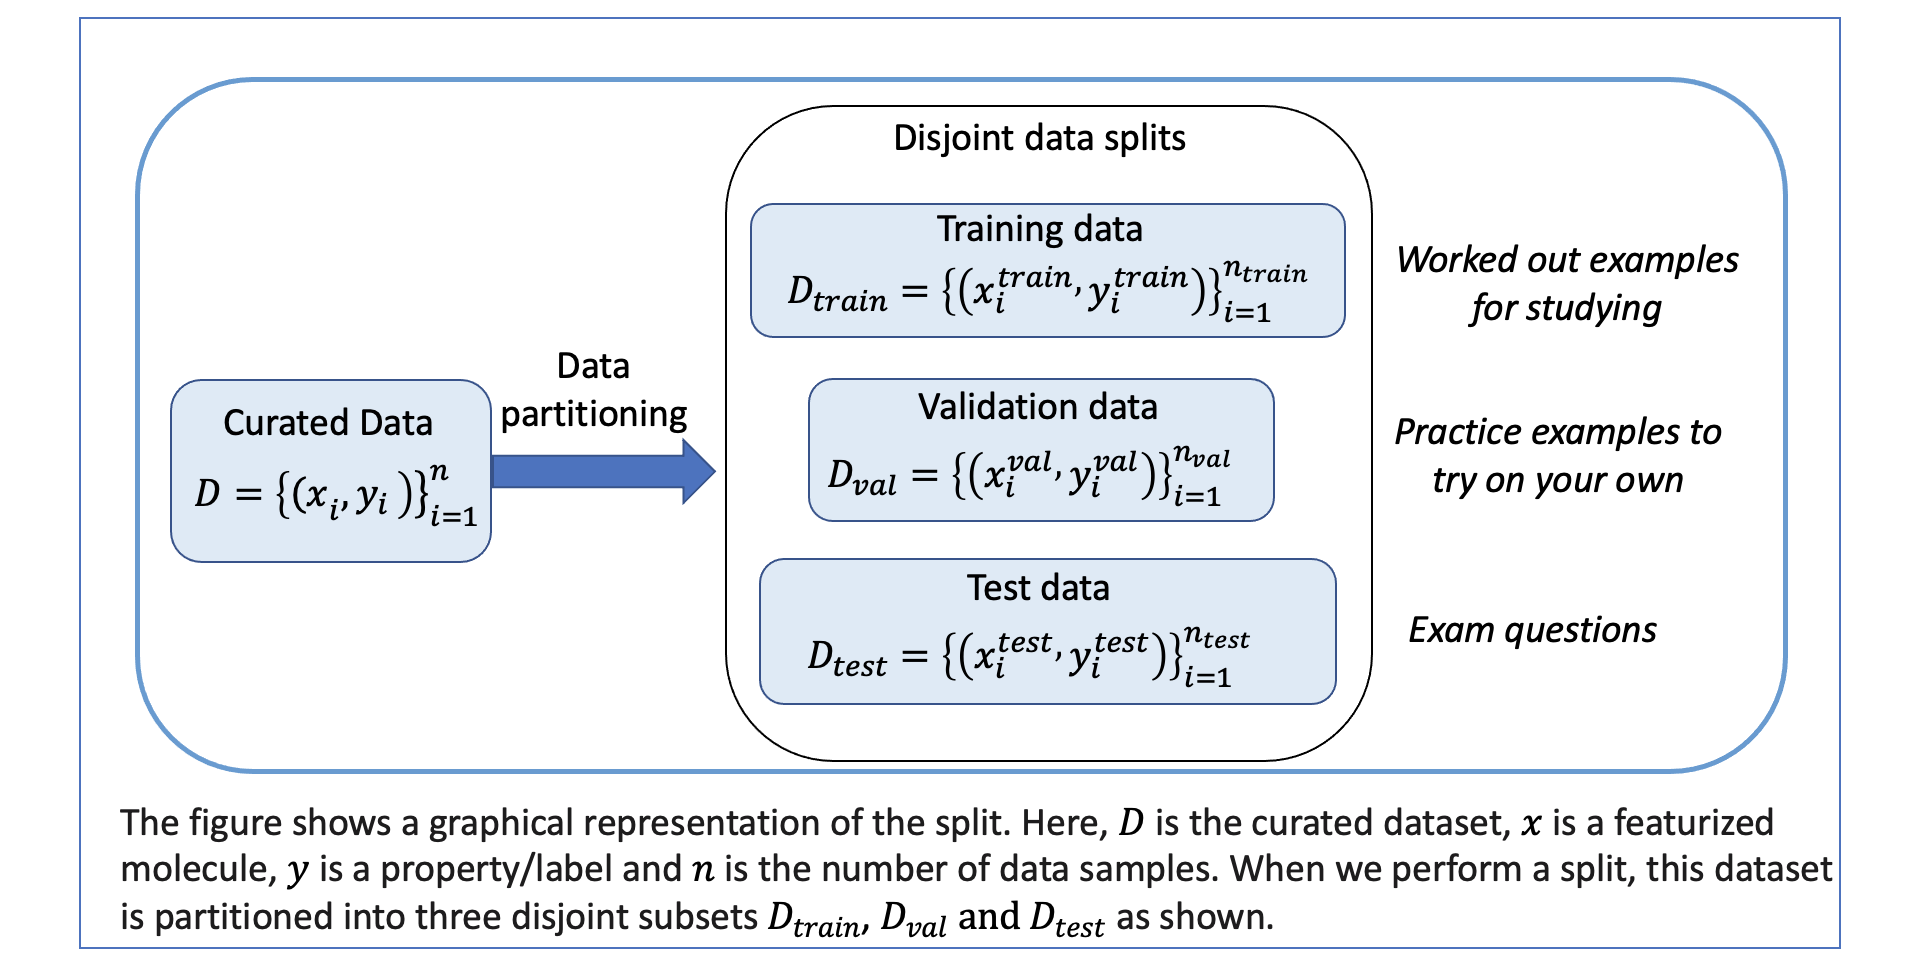

_Comment: I think the "practice examples" metaphor for the validation set is misleading; it certainly doesn't
illuminate the purpose of having separate validation and test sets._

In [1]:
'''We will use the curated dataset that we created in tutorial 2 
and learn how to split it into train,validation and test sets.'''

import pandas as pd

# Set up
dataset_file = 'dataset/curated_kcna3_ic50.csv'
odir='dataset'

Machine learning (ML) models learn the relationship between molecules and molecular properties.
ML models can dramatically accelerate the screening process by providing researchers information 
on which molecules are most and least likely to have the desired properties.

ML models, however, are only as good as the data they were trained on. In the chemical space, 
this problem manifests itself when a model is queried with molecules from an unfamiliar chemical space. 

## Performing splits

Scaffolds represent core structures of small molecules. Scaffold splits group molecules with different 
scaffold structures into the training, validation and test sets so that molecules with the same 
scaffold are grouped together in the same subset. As a result, this ensures that the 
train, validation, and test sets are structurally different. 

A scaffold split is more challenging than a random split where the data are split into 
train, validation, and test sets at random. If a model is trained on molecules that 
belong to only a handful of scaffold classes, its ability to predict a 
molecule in an unfamiliar scaffold is unknown.

### Rationale between using scaffold split and random split

A generalizable model will be able to accurately predict the properties of molecules it has never seen before, 
reducing the need to perform extensive manual assays each time a new chemical class is to be tested. 
Generalizable models can predict across multiple different scaffolds and molecule types, while a non-generalizable model cannot.

A scaffold split tests model generalizability better than a random split. When using a random split, there is no guarantee that the test set will be structurally different than the training sets.

In [8]:
split_type=['scaffold','random']
param_lst=[]
for split_val in split_type :
    params = {
        "verbose": "True",
        "system": "LC",

        # dataset info
        "dataset_key" : dataset_file,
        "datastore": "False",
        "response_cols" : "avg_pIC50",
        "id_col": "compound_id",
        "smiles_col" : "base_rdkit_smiles",
        "result_dir": odir,

        # splitting
        "split_only": "True",
        "previously_split": "False",
        "splitter": split_val,
        "split_valid_frac": "0.15",
        "split_test_frac": "0.15",

        # featurization & training params
        "featurizer": "computed_descriptors",
        "descriptor_type" : "rdkit_raw",
    }
    param_lst.append(params)

Splits are created by creating a `ModelPipeline` and then calling the `split_dataset` function.

In [9]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

split_lst=[]
for params in param_lst :
    pparams = parse.wrapper(params)
    MP = mp.ModelPipeline(pparams)
    split_uuid = MP.split_dataset()
    split_lst.append((params,split_uuid))

INFO:ATOM:Created a dataset hash '389b161b7a4eb2304323a7dfddacfacc' from dataset_key '/usr/WS1/he6/code/ATOM/AMPL1.6/atomsci/ddm/examples/tutorials2023/dataset/curated_kcna3_ic50.csv'
INFO:ATOM:Reading descriptor spec table from /usr/WS1/he6/code/ATOM/AMPL1.6/atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv
DEBUG:ATOM:Attempting to load featurized dataset
DEBUG:ATOM:Got dataset, attempting to extract data
DEBUG:ATOM:Creating deepchem dataset
INFO:ATOM:Using prefeaturized data; number of features = 200
INFO:ATOM:Created a dataset hash '389b161b7a4eb2304323a7dfddacfacc' from dataset_key '/usr/WS1/he6/code/ATOM/AMPL1.6/atomsci/ddm/examples/tutorials2023/dataset/curated_kcna3_ic50.csv'
DEBUG:ATOM:Attempting to load featurized dataset
DEBUG:ATOM:Got dataset, attempting to extract data
DEBUG:ATOM:Creating deepchem dataset
INFO:ATOM:Using prefeaturized data; number of features = 200


The dataset split table is saved as a .csv in the same directory as the `dataset_key`. 
The name of the split file starts with the `dataset_key` and is followed by the split type (scaffold/random), 
split strategy, and the split_uuid; an unique identifier of the split.

In [10]:
# display the split file location and names
import os
file_lst=[]
for params, sid in split_lst :
    fname=params['dataset_key']
    dirname=os.path.dirname(fname)
    split_val=params['splitter']

    # find the file that contains the correct uuid
    all_files = os.listdir(dirname)
    for file in all_files:
        if sid in file:
            nfile = os.path.join(dirname, file)
            file_lst.append((nfile,sid,split_val))
            break
print(file_lst)

[('dataset/curated_kcna3_ic50_train_valid_test_scaffold_c0313c63-8936-4297-925b-ee537b66dd89.csv', 'c0313c63-8936-4297-925b-ee537b66dd89', 'scaffold'), ('dataset/curated_kcna3_ic50_train_valid_test_random_74a208f2-d930-4987-bf2f-382487b666c8.csv', '74a208f2-d930-4987-bf2f-382487b666c8', 'random')]


## Format of the split file
The split file consists of three columns: `cmpd_id` is the compound id; `subset` tells you if the compound is in the train, validation, or test set and `fold` tells you the fold.

> **Note**  *K-Fold split stratergies will be explored in a later tutorial* 

In [11]:
# Explore contents of the split file
file,sid,split_val = file_lst[0]
df=pd.read_csv(file)
df.head(3)

,cmpd_id,subset,fold
0,CHEMBL2205329,train,0
1,CHEMBL3609067,train,0
2,CHEMBL3920884,train,0


## Comparison of Random and Scaffold Splits
[Tanimoto distance](https://en.wikipedia.org/wiki/Jaccard_index#Tanimoto_similarity_and_distance) is a handy way 
to measure distance between compounds represented using [ECFP fingerprints](https://pubs.acs.org/doi/10.1021/ci100050t). 
Below, all pairwise tanimoto distances are calculated between training and test sets. Scaffold split have more
compounds in the 0.3 ot 0.5 range than the random split. Both splits contain compounds very similar
to the training set, we can expect good performance on those compounds.

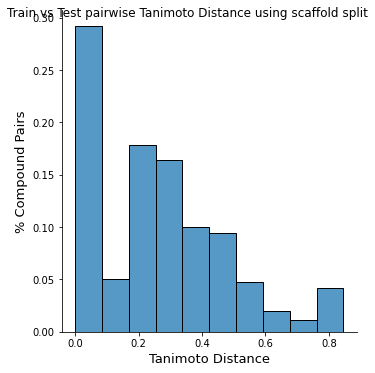

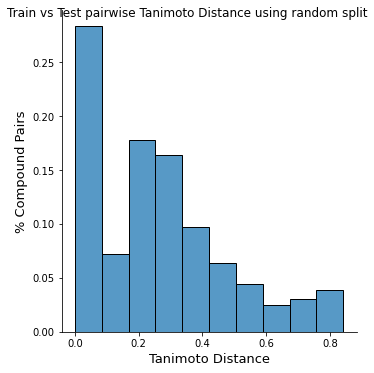

In [12]:
import atomsci.ddm.utils.compare_splits_plots as csp
from atomsci.ddm.pipeline import chem_diversity as cd

# read the dataset
df = pd.read_csv('dataset/curated_kcna3_ic50.csv')

for file, uuid, split_type in file_lst:
    # read the split file
    split = pd.read_csv(file)

    # create SplitStats
    ss = csp.SplitStats(df, split, smiles_col='base_rdkit_smiles', id_col='compound_id', response_cols=['avg_pIC50'])

    g = ss.dist_hist_train_v_test_plot()
    g.fig.suptitle(f"Train vs Test pairwise Tanimoto Distance using {split_type} split")